In [25]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew, kurtosis
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore')

# plt 기본 그래프 스타일 바꾸기
plt.style.use('tableau-colorblind10')
cust_color = [
    '#EDC7B7',
    '#EEE2DC',
    '#BAB2B5',
    '#123C69',
    '#AC3B61'
]
plt.rcParams['figure.figsize'] = (12,4)
plt.rcParams['figure.dpi'] = 300
plt.rcParams["axes.grid"] = False
plt.rcParams["grid.color"] = cust_color[3]
plt.rcParams["grid.alpha"] = 0.5
plt.rcParams["grid.linestyle"] = '--'
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams['axes.unicode_minus'] = False

plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.linewidth'] = 0.5


## Data Loading

In [3]:
# 데이터 dir path
PATH = 'data/'

train = pd.read_csv(PATH+'train.csv')
greeks = pd.read_csv(PATH+'greeks.csv')
test = pd.read_csv(PATH+'test.csv')
# remove blank in column name
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [4]:
# 범주형 column와 비범주형 column 분리
num_cols = train.columns.tolist()[1:-1]
cat_cols = 'EJ'
num_cols.remove(cat_cols)

In [6]:
# 표준 편차 탑 20을 저장 
features_std = train.loc[:,num_cols].apply(lambda x: np.std(x)).sort_values(
    ascending=False)
f_std = train[features_std.iloc[:20].index.tolist()]

# 왜도값을 구한 후 top  20 개를 skewed 에 저장
with pd.option_context('mode.use_inf_as_na', True):
    features_skew = np.abs(train.loc[:,num_cols].apply(lambda x: np.abs(skew(x))).sort_values(
        ascending=False)).dropna()
skewed = train[features_skew.iloc[:20].index.tolist()]

# 첨도를 구한 후 top  20 개를 kurt_f 에 저장
with pd.option_context('mode.use_inf_as_na', True):
    features_kurt = np.abs(train.loc[:,num_cols].apply(lambda x: np.abs(kurtosis(x))).sort_values(
        ascending=False)).dropna()
kurt_f = train[features_kurt.iloc[:20].index.tolist()]

In [8]:
def feat_dist(df, cols, rows=3, columns=3, title=None, figsize=(30, 30)):
    """
    args : 
        df : input pandas DataFrame , 
        cols : column name in df , 
        row : subplots row size , 
        columns : subplots column size 
        title : plots title,
        figsize : total subplots size
    """
    fig, axes = plt.subplots(rows, columns, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()

    for i, j in zip(cols, axes):
        sns.kdeplot(df, x=i, ax=j, hue='Class', linewidth=1.5, linestyle='--')
        
        (mu, sigma) = norm.fit(df[i])
        
        xmin, xmax = j.get_xlim()[0], j.get_xlim()[1]
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, sigma)
        j.plot(x, p, 'k', linewidth=2)
        
        j.set_title('Dist of {0} Norm Fit: $\mu=${1:.2g}, $\sigma=${2:.2f}'.format(i, mu, sigma), weight='bold')
        j.legend(labels=[f'Class0_{i}', f'Class1_{i}', 'Normal Dist'])
        fig.suptitle(f'{title}', fontsize=24, weight='bold')

#### 모든 column을 사용하는 대신 이상이 있는 특정 컬럼만 확인 한다.

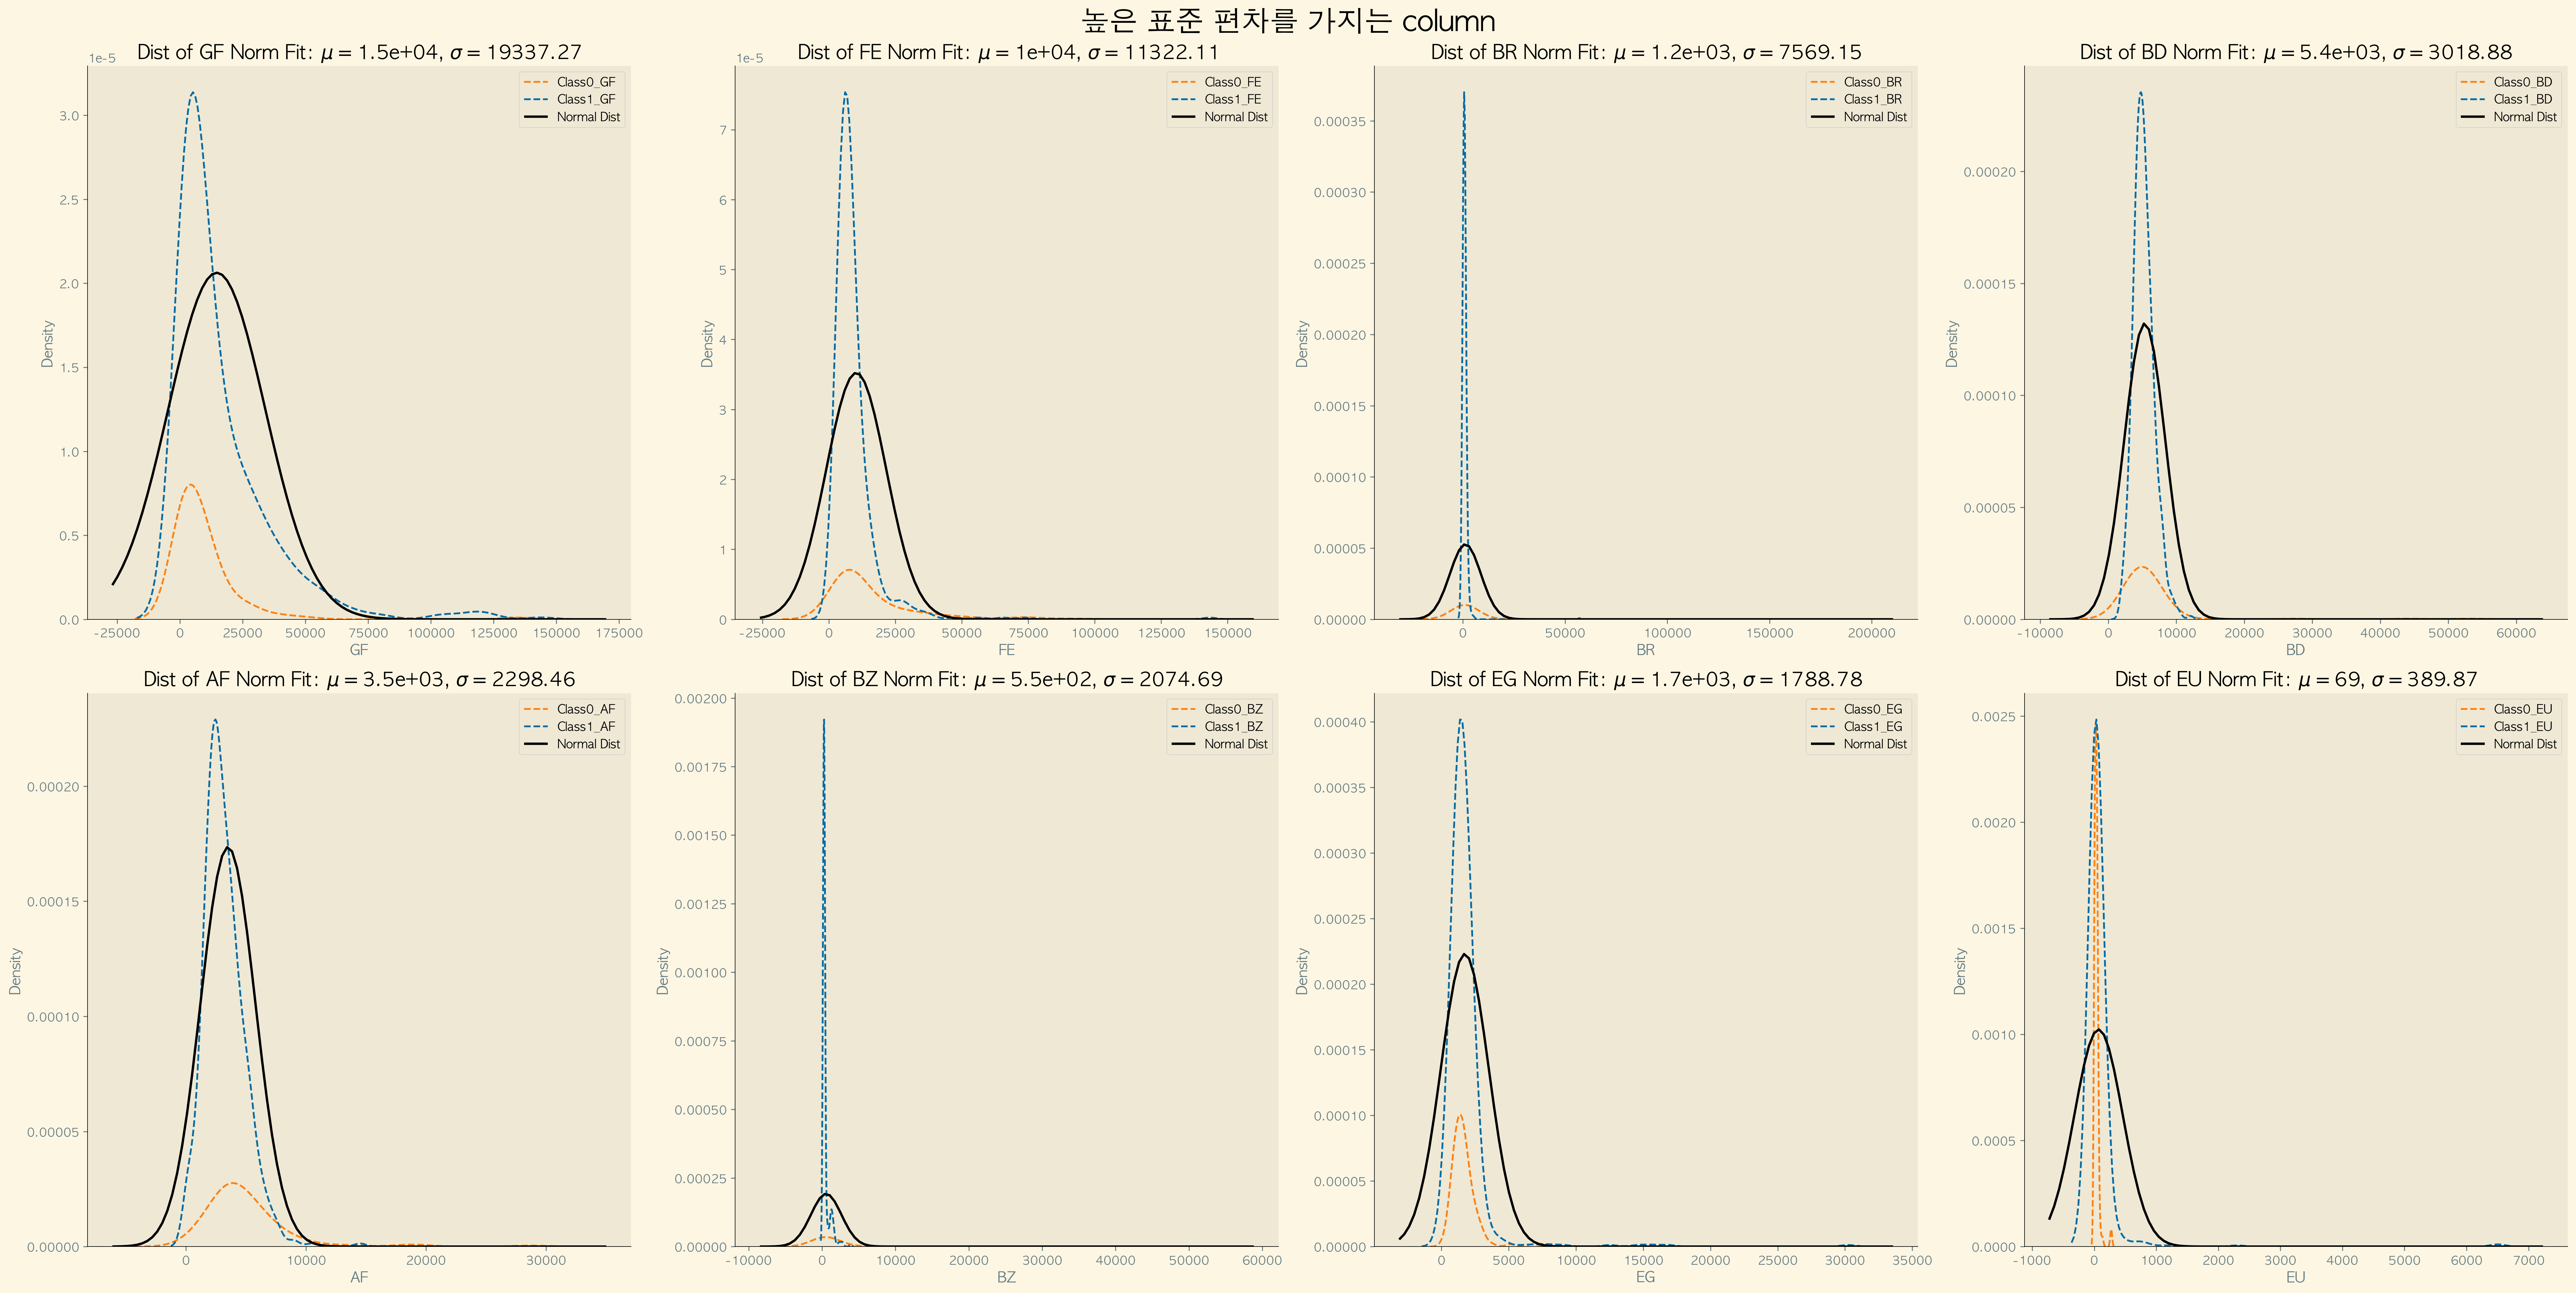

In [26]:
feat_dist(train,
        f_std.columns.tolist(), 
        rows=2, 
        columns=4, 
        title='높은 표준 편차를 가지는 column', 
        figsize=(30, 15))

위의 그래프를 통해 표준 편차 이상값의 분포가 클래스별로 아주 큰 차이가 나는 것을 알 수 가 있다. 

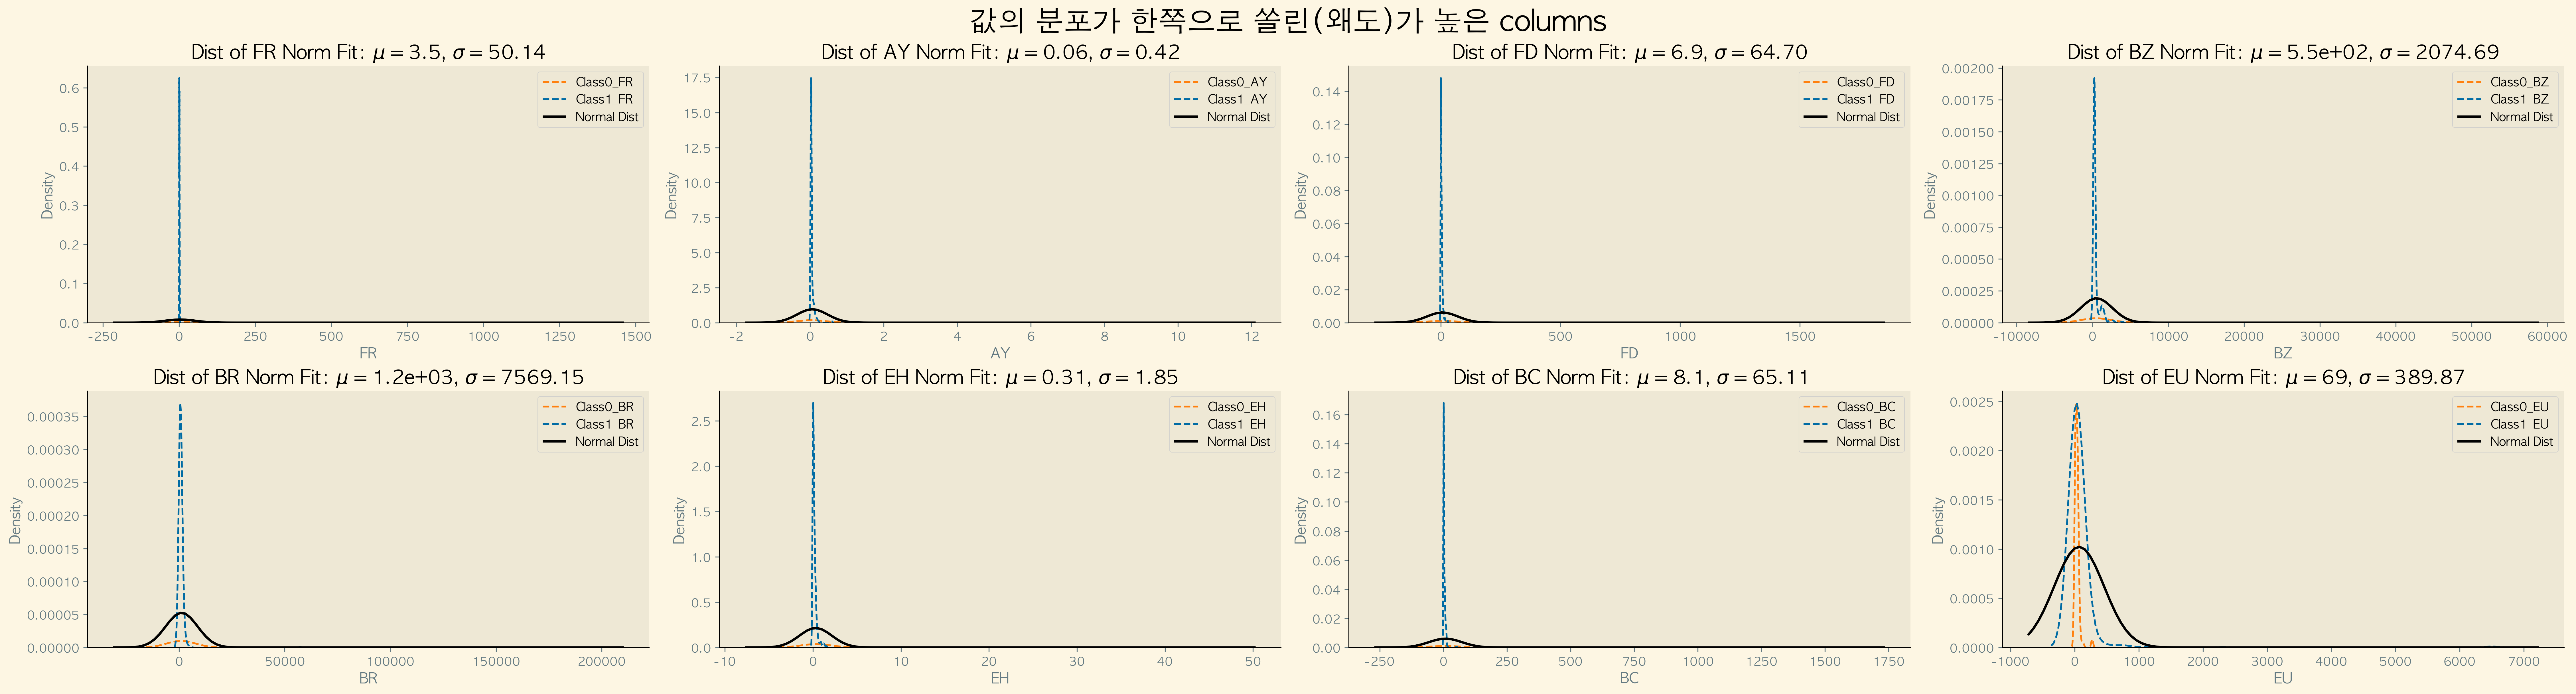

In [27]:
feat_dist(train, skewed.columns.tolist(), rows=2, columns=4, title='값의 분포가 한쪽으로 쏠린(왜도)가 높은 columns', figsize=(30, 8))

왜도 또한 똑같은 패턴을 보인다.

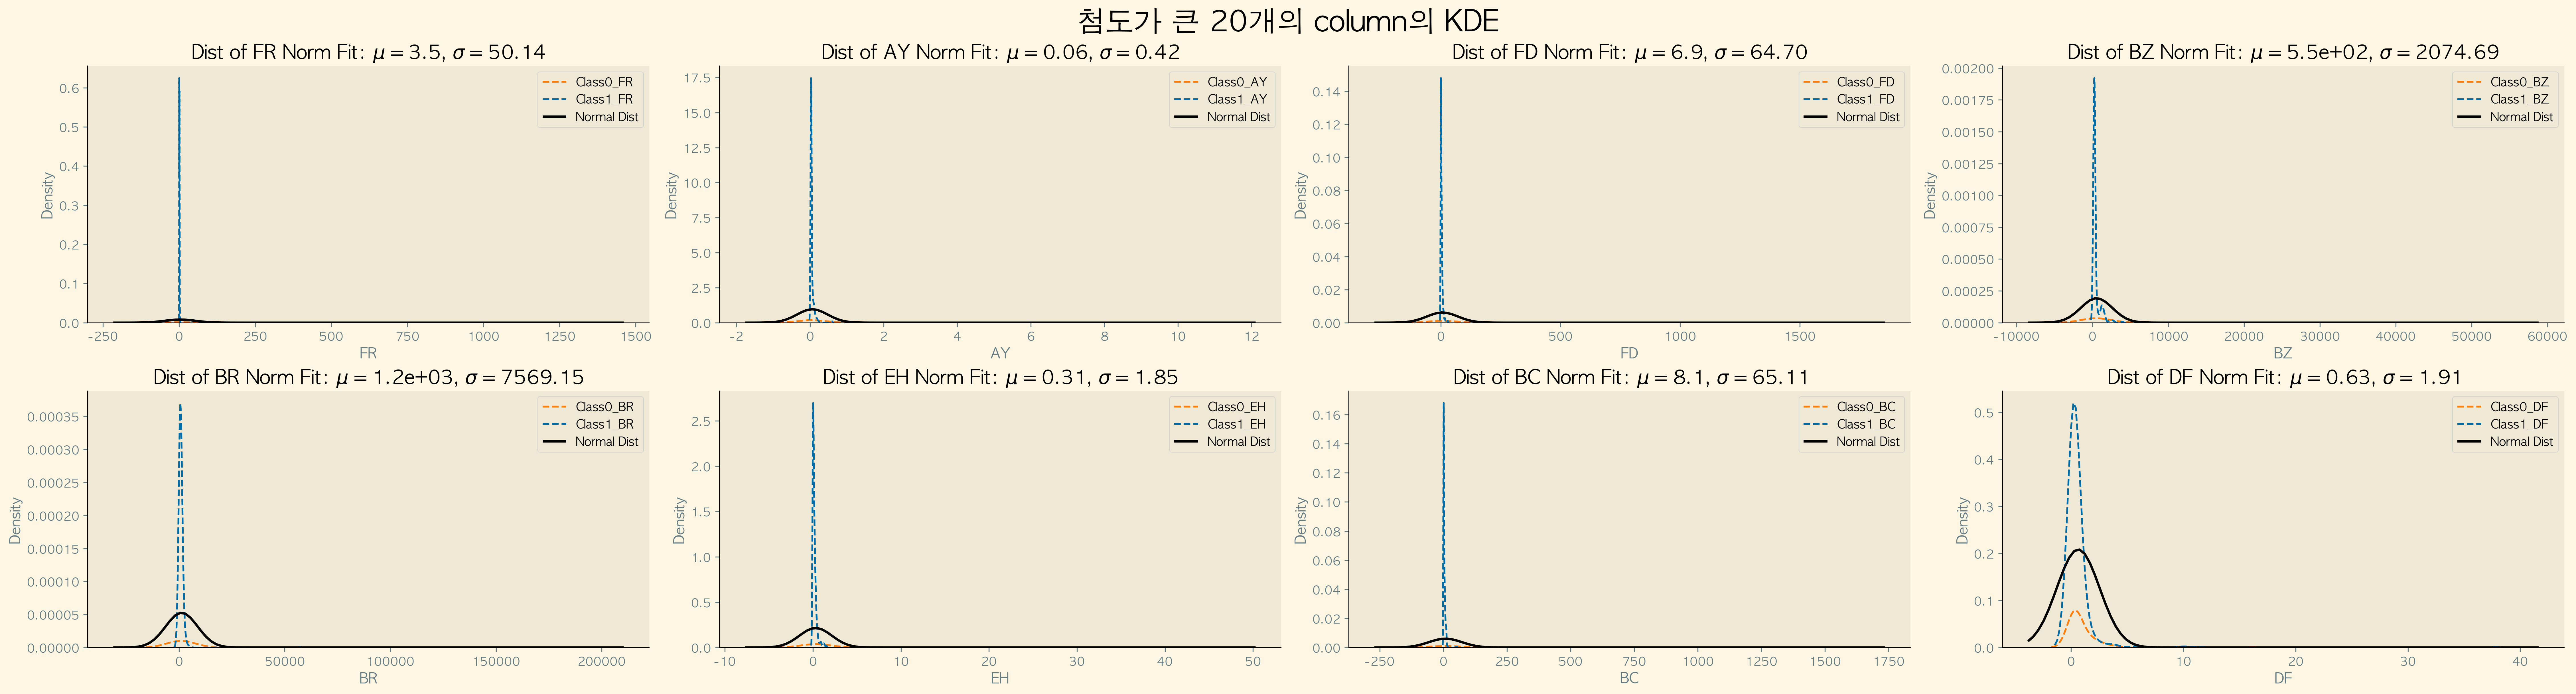

In [29]:
feat_dist(train, kurt_f.columns.tolist(), rows=2, columns=4, title='첨도가 큰 20개의 column의 KDE', figsize=(30, 8))


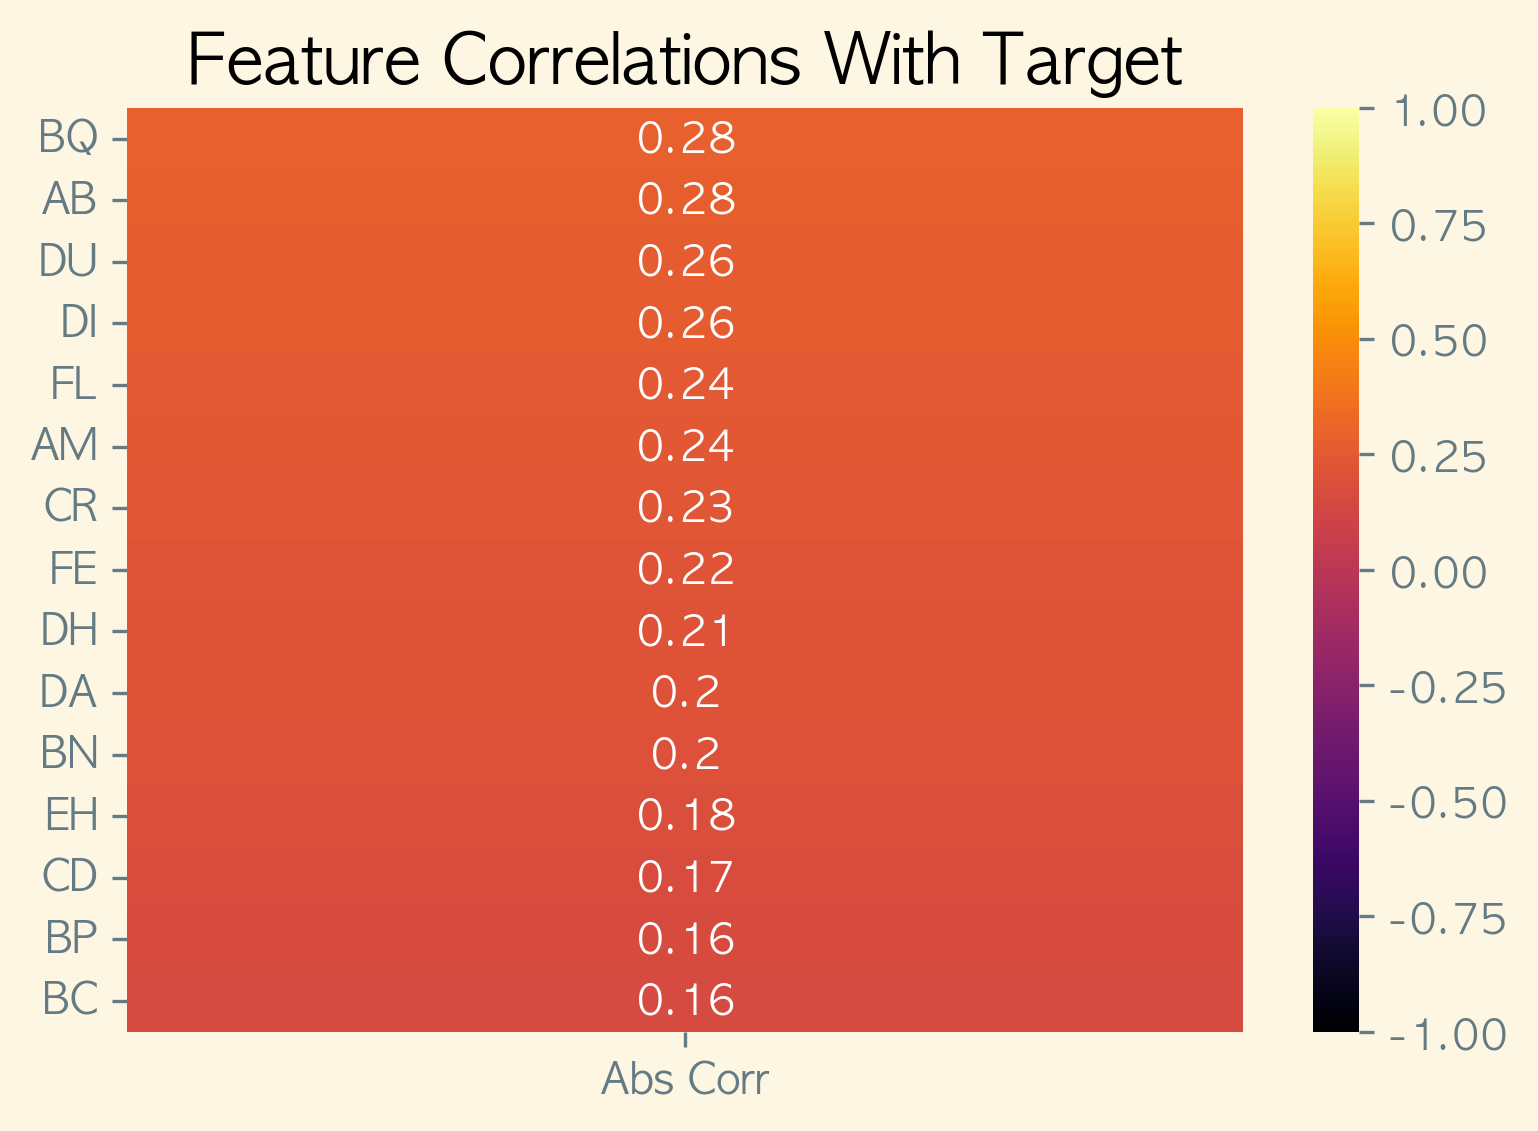

In [30]:
# target 값과의 상관 계수 그래프

correlations = train.loc[:,num_cols].corrwith(train['Class']).to_frame()
correlations['Abs Corr'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('Abs Corr', ascending=False)['Abs Corr']
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(sorted_correlations.iloc[1:].to_frame()[sorted_correlations>=.15], cmap='inferno', annot=True, vmin=-1, vmax=1, ax=ax)
plt.title('Feature Correlations With Target')
plt.show()


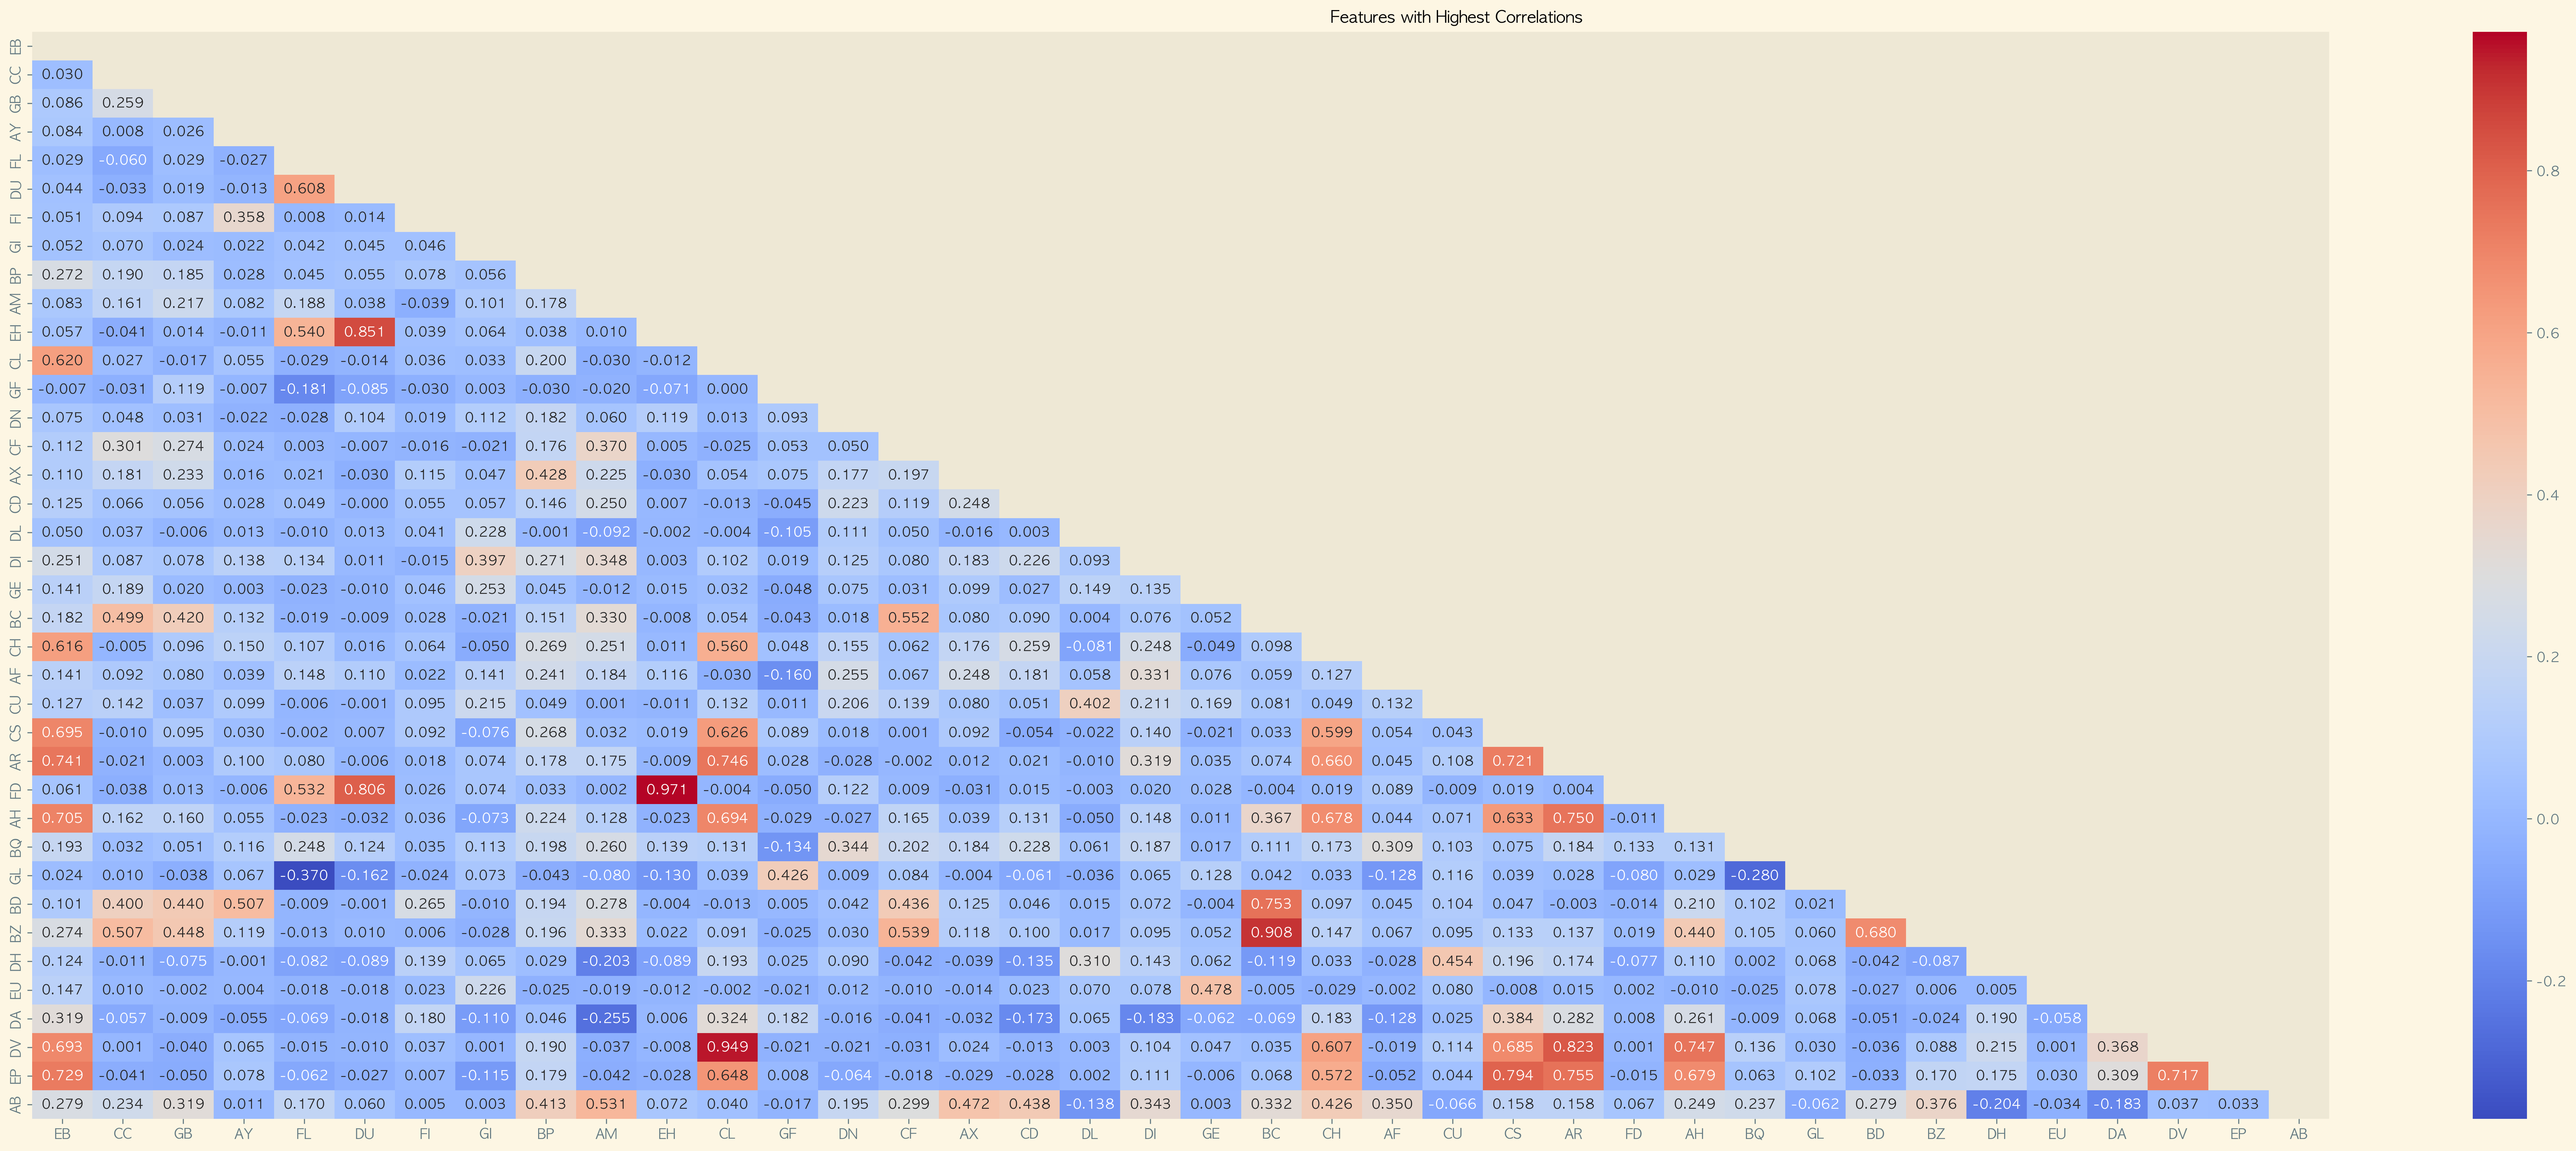

In [31]:
# column간의 상관관계도

correlations = train.loc[:,num_cols].corr().abs().unstack().sort_values(kind="quicksort",ascending=False).reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']] #preventing 1.0 corr
corr_max=correlations.level_0.head(150).tolist()
corr_max=list(set(corr_max)) #removing duplicates

corr_min=correlations.level_0.tail(34).tolist()
corr_min=list(set(corr_min)) #removing duplicates


correlation_train = train.loc[:,corr_max].corr()
mask = np.triu(correlation_train.corr())

plt.figure(figsize=(30, 12))
sns.heatmap(correlation_train,
            mask=mask,
            annot=True,
            fmt='.3f',
            cmap='coolwarm',
            linewidths=0.00,
            cbar=True)


plt.suptitle('Features with Highest Correlations',  weight='bold')
plt.tight_layout()

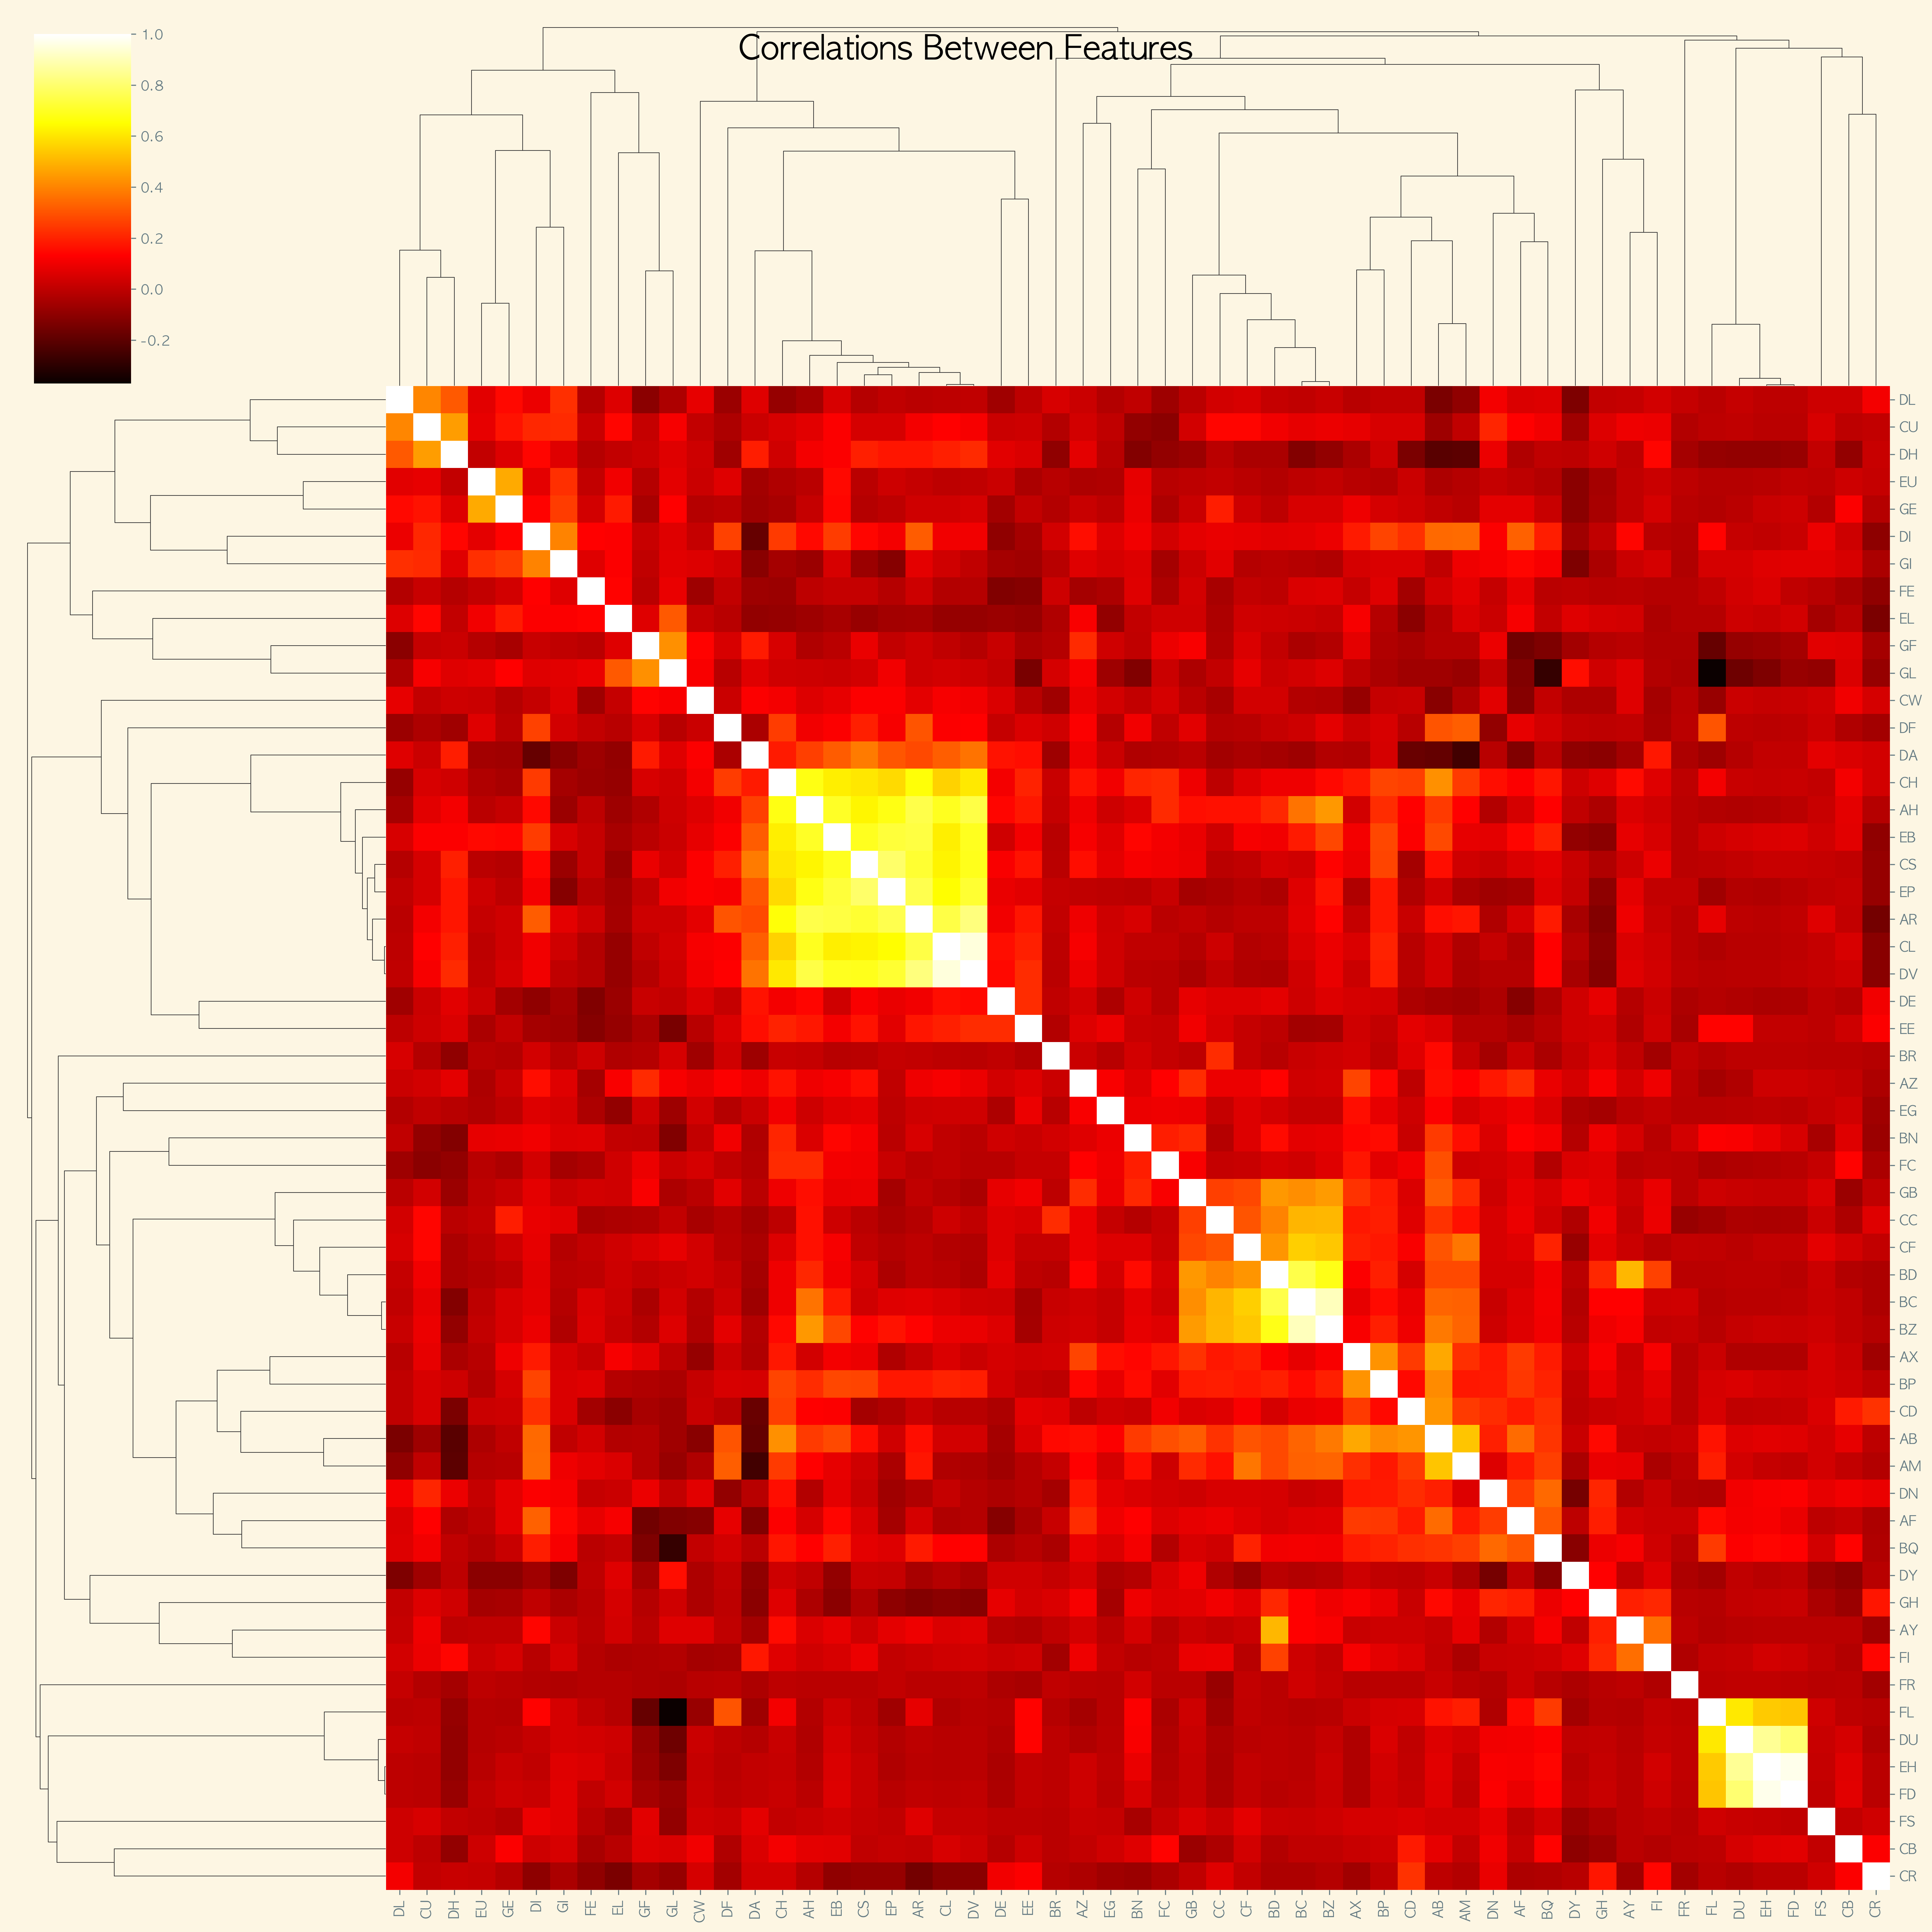

In [32]:
# heatmap 이 아닌 다른 그래프로 살펴보자
corr = train.loc[:, num_cols].corr()
sns.clustermap(corr, metric="correlation", cmap="hot", figsize=(20, 20))
plt.suptitle('Correlations Between Features', fontsize=24, weight='bold')
plt.show()

#### 위의 상관관계 그래프를 보면 서로 강한 상관관계를 가진 column이 존재하는 것을 알 수가 있다,

In [35]:
correlations

level_0 level_1         0
55        EH      FD  0.971152
56        FD      EH  0.971152
57        CL      DV  0.948991
58        DV      CL  0.948991
59        BC      BZ  0.907981
...      ...     ...       ...
3020      BZ      CB  0.000086
3021      GF      CL  0.000071
3022      CL      GF  0.000071
3023      DF      FC  0.000036
3024      FC      DF  0.000036

[2970 rows x 3 columns]

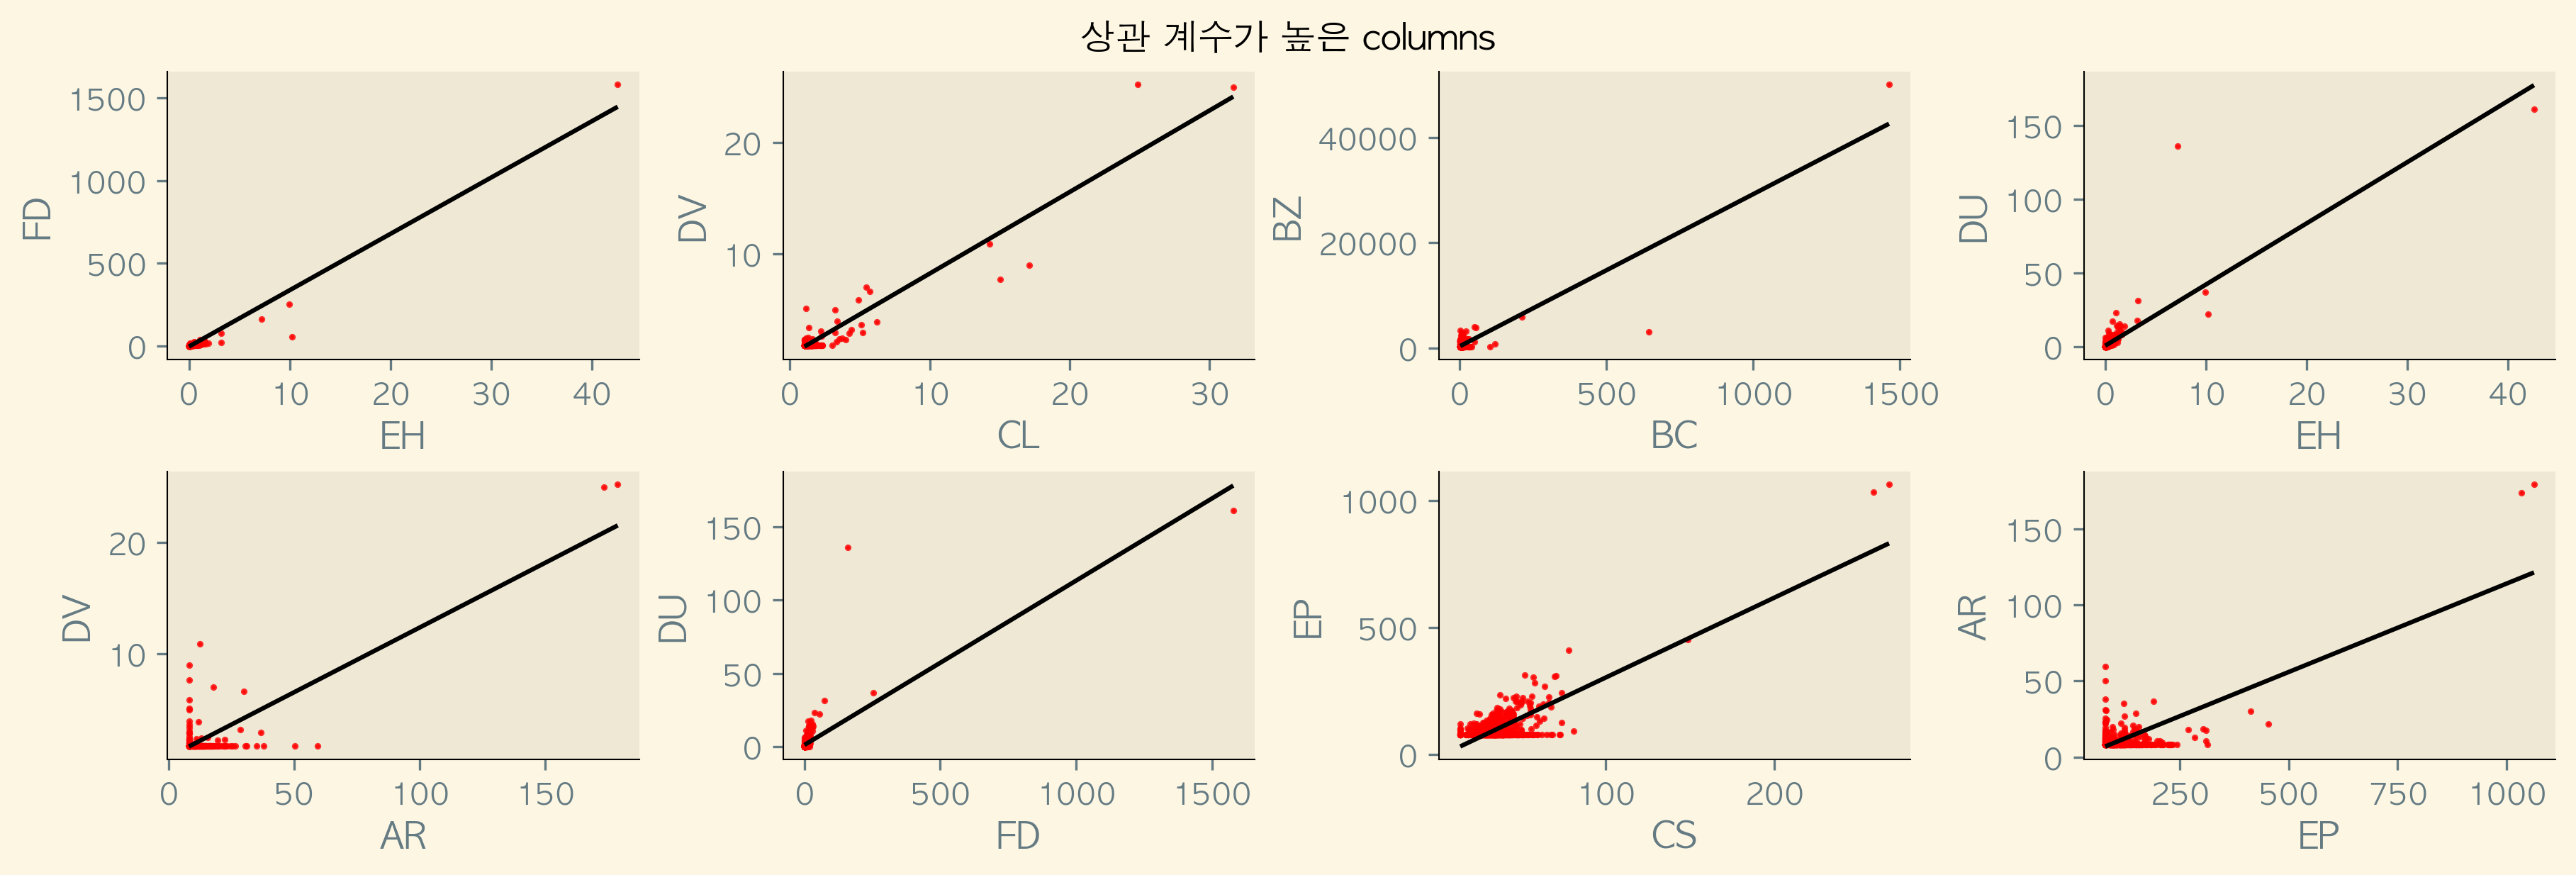

In [34]:
fig, axes = plt.subplots(2, 4, figsize=(12,4), constrained_layout=True)
axes = axes.flatten()

# for i, j in zip(cols, axes):
i = 0
for row in range(0,16,2):
    a = correlations.reset_index(drop=True).loc[row, ['level_0', 'level_1']][0]
    b = correlations.reset_index(drop=True).loc[row, ['level_0', 'level_1']][1]    
   
    sns.regplot(train, x=a, y=b, ci=False, ax=axes[i], order=1, scatter_kws={'color':'red', 's':1.5}, line_kws={'color':'black', 'linewidth':1.5})
    i+=1
    
plt.suptitle('상관 계수가 높은 columns',  weight='bold')
plt.show()

상관계수가 높은 column들에서 이상치와 영향점이 많이 발견되었다. 

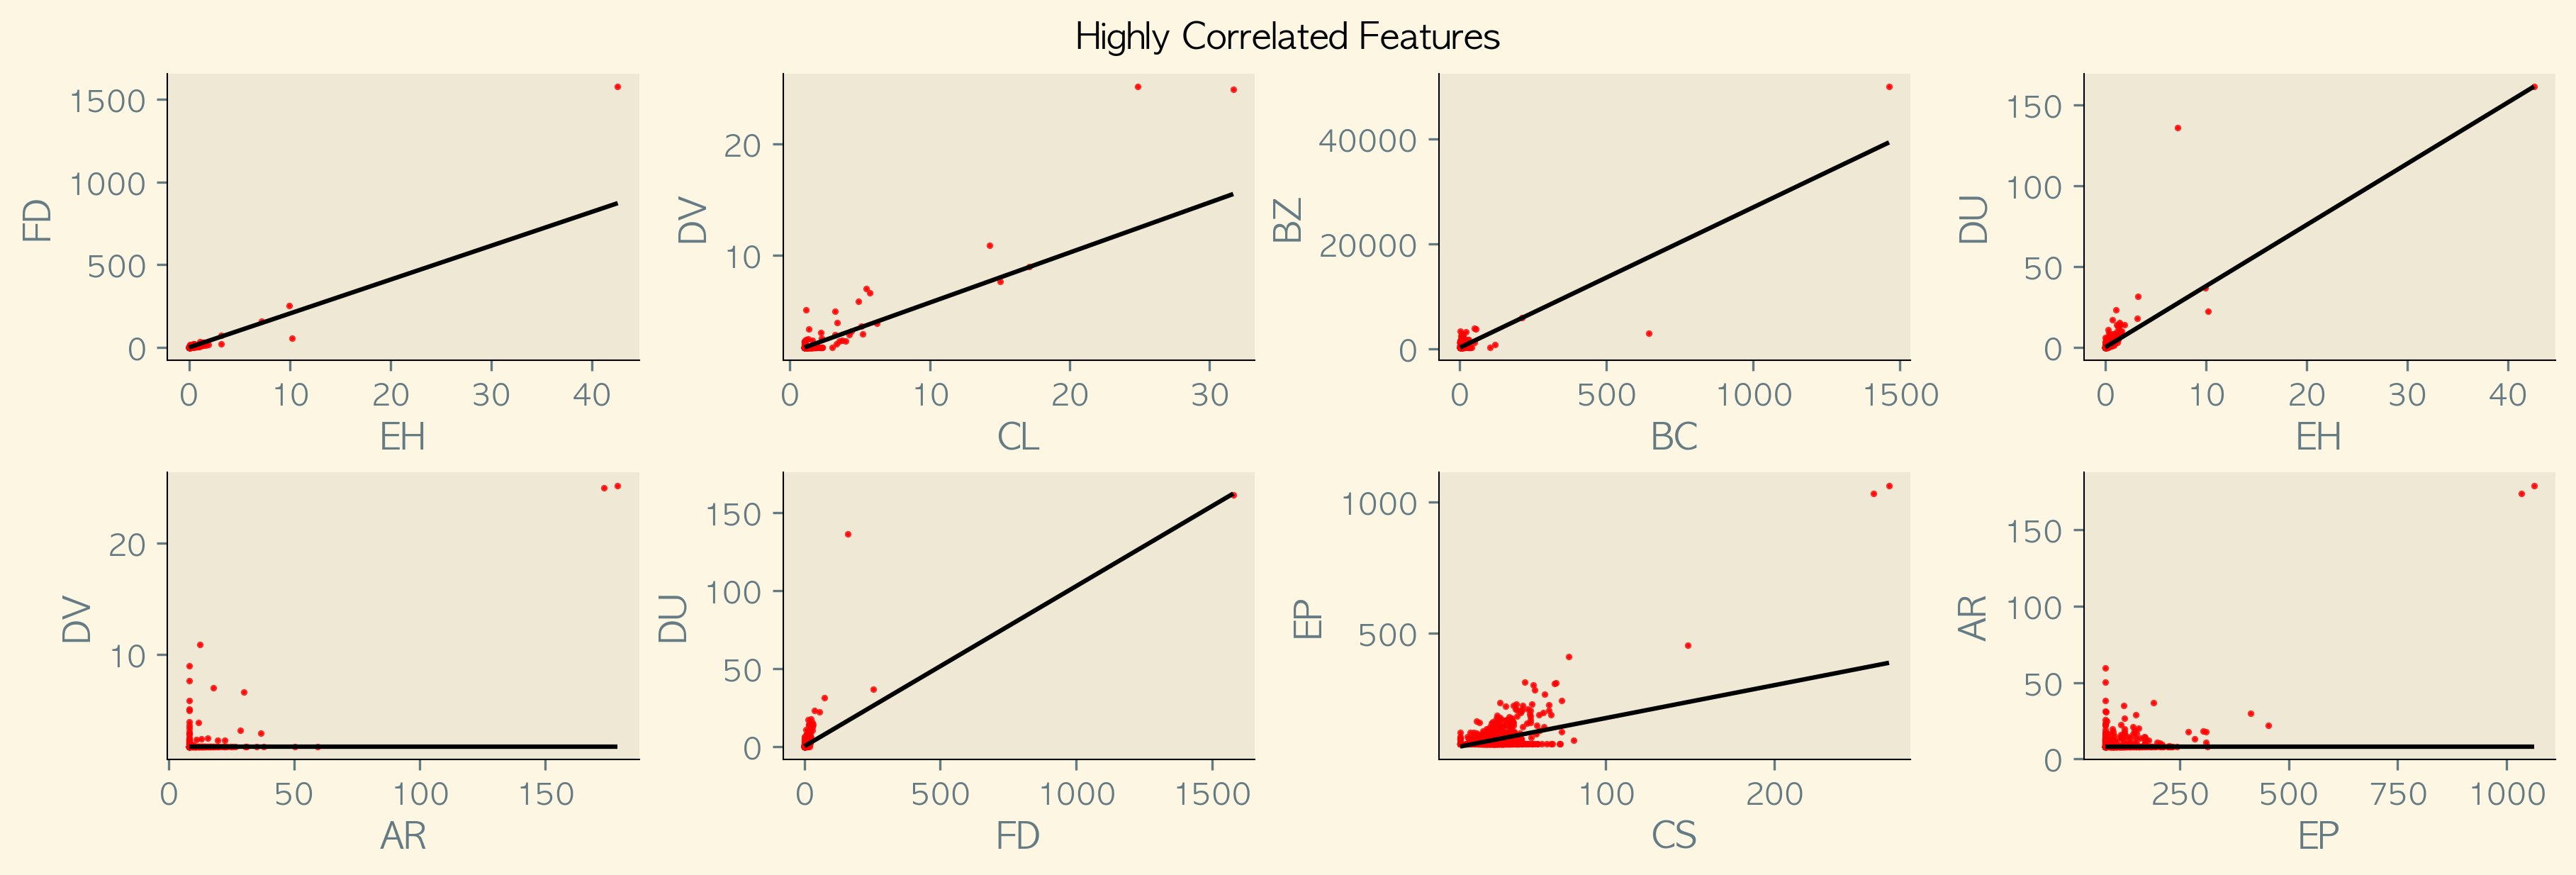

In [36]:
fig, axes = plt.subplots(2, 4, figsize=(12,4), constrained_layout=True)\
# flatten을 왜 할까?
axes = axes.flatten()

# for i, j in zip(cols, axes):
i = 0
for row in range(0,16,2):
    a = correlations.reset_index(drop=True).loc[row, ['level_0', 'level_1']][0]
    b = correlations.reset_index(drop=True).loc[row, ['level_0', 'level_1']][1]
    
   
    sns.regplot(train, x=a, y=b, ci=False, ax=axes[i], robust=True, scatter_kws={'color':'red', 's':1.5}, line_kws={'color':'black', 'linewidth':1.5})
    i+=1
    
plt.suptitle('Highly Correlated Features',  weight='bold')
plt.show()

In [ ]:
실제로 일부 강한 상관관계는 실제로는 그다지 강하지 않은 것처럼 보이지만 일부는 여전히 중요도를 유지하고 있다.